# Classify structured data

This tutorial demonstrates how to classify `structured data` (e.g. tabular data in a CSV). 
And will use Keras to define the model, and [feature columns](https://www.tensorflow.org/guide/feature_columns) as a bridge to map from columns in a CSV to features used to train the model. 

- Load a CSV file using [Pandas](https://pandas.pydata.org/).
- Build an input pipeline to batch and shuffle the rows using [tf.data](https://www.tensorflow.org/guide/datasets).
- Map from columns in the CSV to features used to train the model using feature columns.
- Build, train, and evaluate a model using Keras.


## Import libraries

In [4]:
!pip install -q sklearn pandas

In [5]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

%matplotlib inline

print("Tensorflow version: ", tf.__version__)
print("Tensorflow Keras version: ", tf.keras.__version__)

Tensorflow version:  2.0.0-beta1
Tensorflow Keras version:  2.2.4-tf


## Load a CSV file and create a dataframe

### The Dataset

[Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/heart+Disease)

There are several hundred rows in the CSV. Each row describes a patient, and each column describes an attribute. We will use this information to `predict whether a patient has heart disease`, which in this dataset is a `binary classification` task.
     
<img src="imgs/heart_disease.png" width=70%>

### Use Pandas to read CSV file and create a dataframe

In [8]:
URL = 'https://storage.googleapis.com/applied-dl/heart.csv'
dataframe = pd.read_csv(URL)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [9]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


## Create an input pipeline

We will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [3]:
print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))

print("First review length: ", len(x_train[0]))
print("Second review length: ", len(x_train[1]))

print()
print(x_train[0])

Training entries: 25000, labels: 25000
First review length:  218
Second review length:  189

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103

## Preprocess the data: Convert the integers back to words

In [5]:
# A dictionary mapping words to an integer index
word_index = tf.keras.datasets.imdb.get_word_index()
word_index

In [7]:
# The first indices are reserved
word_index = {k: (v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 

print(reverse_word_index)

def decode_review(text):
    #  dict.get(): returns a value for the given key. 
    #              If key is not available then returns default value.
    #              default value is `None`.
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
decode_review(x_train[0])

"<START> in with i like horrible business chinese charm would killer waited which explosion ? going at fun ? film make like lame character has novel <UNK> a all final sense ? real ? find character nothing <UNK> second perhaps they ? find valuable cover this city an br overall ? horror has i ? should shop was in with ? delightful 00 despite ? with their people is i like horrible an well it br garbage ? with this genre this is i taken that <UNK> ? she sex is and house and after ? ? product bud i final which returned be ? does is i an annoying ? film where if at man it's film sent be ? with is comedy you than some ? in perfect i get <UNK> and ? think plot windows it fun ? <UNK> the lou ? sequence at their like horrible wanted on getting night just the ? <UNK> rich br any other ? couple it someone then he decade more on why ? can't ajay that ? family with for still wanted on final ? such his lindsay that if at you interesting how film any ? family would i an g other is i once ? i boot seen

## Prepare the data

The reivews-the array of integers-must be converted to `tensors` before fed into the neural network.

This conversion can be done a coiple ways:

- One-hot encoding:

    For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones.Then, make this the first layer in our neural network-a Denselayer-that can handle floating point vector data.
    
    * This approch is memory intensive, though, requiring a `num_words * num_reviews` size matrix.


- Pad the arrays:

    So they all have the same length, then create an integer tensor of shape `max_length * num_reviews`.
    
    * We can use an embedding layer capable of handling this shape as the first layer in our neural network.


In this tutorial, we will use the second approach.

[pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences)

In [9]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=256)

print("First review length: ", len(x_train[0]))
print("Second review length: ", len(x_train[1]))
print(x_train.shape)

print()
print(x_train[0])

First review length:  256
Second review length:  256
(25000, 256)

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480

## Create a validation set

In [10]:
x_valid = x_train[:10000]
x_train = x_train[10000:]

y_valid = y_train[:10000]
y_train = y_train[10000:]

print("training set: {}".format(x_train.shape[0]))
print("validation set: {}".format(x_valid.shape[0]))

training set: 15000
validation set: 10000


## Build the model

In [11]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = tf.keras.Sequential()

model.add(Embedding(vocab_size, 16))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

## Train the model

In [13]:
history = model.fit(x_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

W0907 14:44:05.829052 139803710854976 deprecation.py:323] From /usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 120us/sample - loss: 0.6918 - acc: 0.6226 - val_loss: 0.6896 - val_acc: 0.6865
Epoch 2/40
15000/15000 [==============================] - 1s 68us/sample - loss: 0.6858 - acc: 0.7355 - val_loss: 0.6818 - val_acc: 0.7415
Epoch 3/40
15000/15000 [==============================] - 1s 73us/sample - loss: 0.6731 - acc: 0.7556 - val_loss: 0.6655 - val_acc: 0.7616
Epoch 4/40
15000/15000 [==============================] - 1s 75us/sample - loss: 0.6505 - acc: 0.7615 - val_loss: 0.6399 - val_acc: 0.7624
Epoch 5/40
15000/15000 [==============================] - 1s 74us/sample - loss: 0.6175 - acc: 0.7923 - val_loss: 0.6054 - val_acc: 0.7870
Epoch 6/40
15000/15000 [==============================] - 1s 69us/sample - loss: 0.5758 - acc: 0.8137 - val_loss: 0.5651 - val_acc: 0.8034
Epoch 7/40
15000/15000 [==============================] - 1s 74us/sample - loss: 0.5290 - acc: 0.8271 - val_loss: 0

## Evaluate the model

In [14]:
results = model.evaluate(x_test, y_test)
print("Test Acc: ", results[1])

25000/25000 [==============================] - 3s 112us/sample - loss: 0.3287 - acc: 0.8719
Test Acc:  0.87192


## Create a graph of accuracy and loss over time

`model.fit()` returns a History object that contains a dictionary with everything that happened during training:

In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

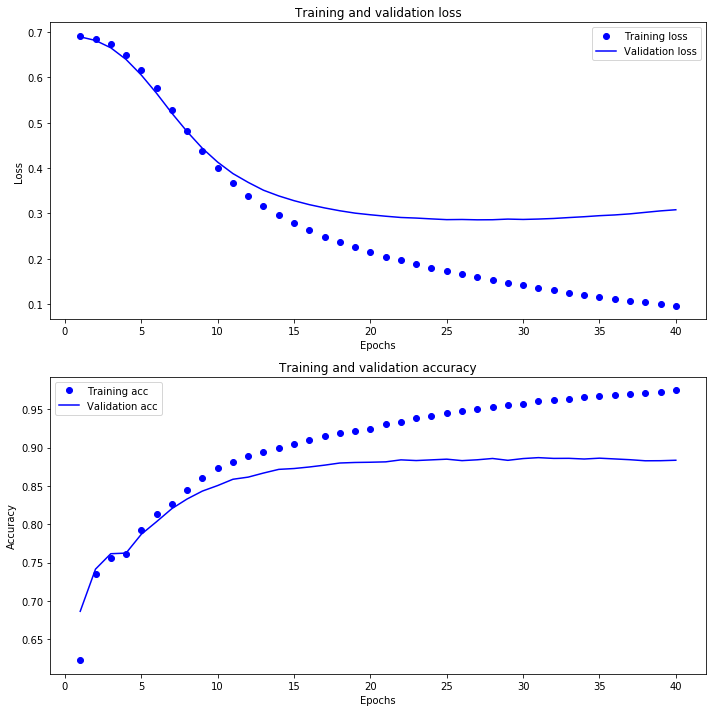

In [16]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()